In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import os
from torch import nn
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn.metrics import precision_score, confusion_matrix
from tqdm import tqdm
from datetime import datetime
# Start the timer
from timeit import default_timer as timer
import engine, helper_functions
# from clearml import Task
# task = Task.init(project_name="exploration/AiCoinXpert", task_name="task0.0.1")
# task.execute_remotely(queue_name="kube-cuda11.0_high_priority_01", exit_process=True)
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup
except:
    # Get the going_modular scripts
    # print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    # !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # !mv pytorch-deep-learning/going_modular .
    # !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup

/home/abermond/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# In dev container :

# train_dir ="/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/train/"
# test_dir = "/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/test/"
# eval_dir = "/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/eval/"

# Working without in dev container use the following paths :

train_dir = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/train"
test_dir = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/test/"
eval_dir = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/webscraping/data/organized_images_20_above_filtered/eval/"

# Setup Workers
NUM_WORKERS = torch.cuda.device_count() if torch.cuda.is_available() else os.cpu_count()
NUM_WORKERS

1

In [4]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# Create the training and testing datasets
train_dataset = datasets.ImageFolder(train_dir, transform=manual_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=manual_transforms)
eval_dataset = datasets.ImageFolder(eval_dir, transform=manual_transforms)

# Create training DataLoader with a full batch
#train_dataloader = data_setup.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=NUM_WORKERS)
#test_dataloader = data_setup.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=NUM_WORKERS)
#eval_dataloader = data_setup.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=NUM_WORKERS)

# Create training DataLoader with a mini batch
train_dataloader = data_setup.DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = data_setup.DataLoader(test_dataset, batch_size=25, shuffle=False, num_workers=NUM_WORKERS)
eval_dataloader = data_setup.DataLoader(eval_dataset, batch_size=25, shuffle=False, num_workers=NUM_WORKERS)


# Get a list of class names
class_names = train_dataset.classes  # Assuming both train_dataset and test_dataset have the same class names

# Move to GPU if available
#train_dataloader = train_dataloader.to(device)
#test_dataloader = test_dataloader.to(device)

# Create training and testing DataLoaders as well as get a list of class names
#train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               #test_dir=test_dir,
                                                                               #transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               #batch_size=25)
len(class_names), len(train_dataset)

(198, 69300)

In [5]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# weights
# print(len(model.layers))

In [6]:
#weights = torchvision.models.DenseNet121_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b7(weights=weights).to(device)


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [8]:
# Print a summary using torchinfo (uncomment for actual output)
model_summary = summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [9]:
#model_summary

In [10]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2560,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1.0)

param_grid = {
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [64, 128, 256],
    "weight_decay": [0.0, 0.4, 1]
}

In [12]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       eval_dataloader=eval_dataloader,
                       optimizer=torch.optim.Adam(model.parameters()),
                       loss_fn=loss_fn,
                       epochs=1,
                       device=device,
                       patience=0,
                       param_grid=param_grid)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | Params: {'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.0}


Epoch: 1 | Training Loss: 1.6384 | Training Accuracy: 0.7095
Epoch: 1 | Testing Loss: 1.1247 | Testing Accuracy: 0.7840
Epoch: 1 | Evaluation Loss: 1.1240 | Evaluation Accuracy: 0.7830
Best params: {'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.0}
Epoch: 1 | Params: {'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.4}


  0%|          | 0/1 [31:49<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Save the model

now = datetime.now()
model_save_path = f"/home/abermond/Desktop/workspaces/AICoinXpert/algo/train_{now.strftime('%m_%d_%Y_%H_%M')}.pth"
torch.save(model.state_dict(), model_save_path)

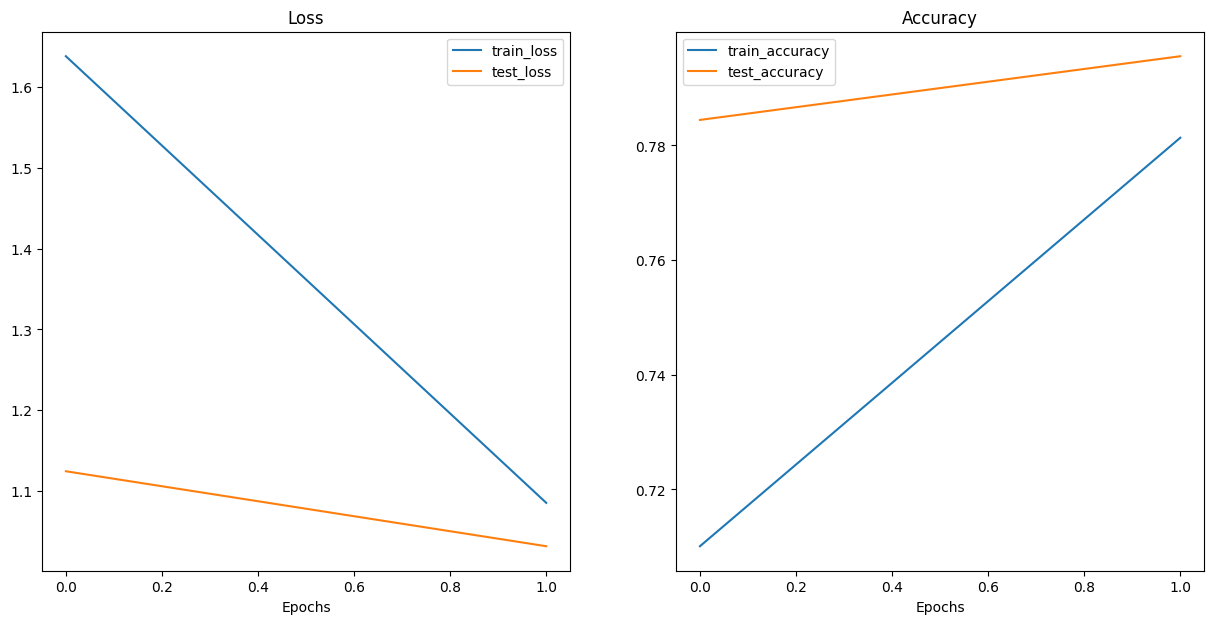

In [15]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
#try:
from helper_functions import plot_loss_curves, get_classification_report, get_confusion_matrix
    
# except:
#     print("[INFO] Couldn't find helper_functions.py, downloading...")
#     with open("helper_functions.py", "wb") as f:
#         import requests
#         request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
#         f.write(request.content)
#     from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## Evaluation metrics including (classification report, confusion matrix)

In [16]:
train_classification_report = get_classification_report(
    model, test_dataloader, device, class_names)

KeyboardInterrupt: 

In [ ]:
import json

# save to a text file the classification report
with open(
    f"/home/abermond/Desktop/workspaces/AICoinXpert/algo/test_class_report_{now.strftime('%m_%d_%Y_%H_%M')}.json",
    "w",
) as f:
    json.dump(train_classification_report, f)

In [ ]:
file_path_test_report = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/test_class_report_11_08_2023_15_48_classification_report.json"
file_path_train_report = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/train_class_report_11_08_2023_15_48_classification_report.json"
file_path_eval_report = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/eval_class_report_11_08_2023_15_48_classification_report.json"

print("train_classification_report :")
generate_report(file_path_train_report)

print("test_classification_report :")
generate_report(file_path_test_report)

print("eval_classification_report :")
generate_report(file_path_eval_report)

In [ ]:
train_confusion_matrix = get_confusion_matrix(
    model, train_dataloader, device)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=False)
    ax.set(xlabel="Predicted", ylabel="True", title="Confusion matrix")
    plt.yticks(rotation=0)


# usage
plot_confusion_matrix(train_confusion_matrix)

## Add more monitoring of the model

In [ ]:
from torch.nn.modules.activation import LogSoftmax
from __future__ import division, print_function

from datetime import datetime

import time
from dataclasses import dataclass
from typing import List, Optional

import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# Define the ModelName enum
class ModelName:
    """ModelName enum class that contains the available pre-trained models by their names."""

    DENSENET201 = "densenet201"
    RESNET50 = "resnet50"
    VGG16 = "vgg16"


@dataclass
class CustomDataset:
    """Initializes the CustomDataset object that will contain the train, test, and val datasets.

    Args:
        train_dir (str): Train dataset directory
        test_dir (str): Test dataset directory
        val_dir (str): Validation dataset directory
        batch_size (int): Batch size is the number of training examples utilized in one iteration
        shuffle (bool): Whether to shuffle the data or not. Default is True.
    """

    train_dir: str
    test_dir: str
    val_dir: str
    batch_size: int
    shuffle: bool = True
    train_dataloader: Optional[DataLoader] = None
    test_dataloader: Optional[DataLoader] = None
    val_dataloader: Optional[DataLoader] = None



    def __post_init__(self):
        # Define manual transformations
        self.manual_transforms = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        # Load the dataset
        self._create_folder()
        self._load_dataset(self.shuffle)

    def _create_folder(self):
        """
        Load the data and apply the manual transformations
        """
        self.train_dataset = ImageFolder(
            root=self.train_dir, transform=self.manual_transforms
        )
        self.test_dataset = ImageFolder(
            root=self.test_dir, transform=self.manual_transforms
        )
        self.val_dataset = ImageFolder(
            root=self.val_dir, transform=self.manual_transforms
        )
        self.class_names = self.train_dataset.classes
        self.len_class_names = len(self.class_names)

    def _load_dataset(self, shuffle):
        """
        Load the data into train, test, and validation dataloaders

        Args:
            shuffle (bool): Apply shuffling to the data or not
        """
        self.train_dataloader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=shuffle
        )
        self.test_dataloader = DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=shuffle
        )
        self.val_dataloader = DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False
        )


class Model:
    """Model class that will contain the pre-trained model, loss function, and optimizer."""

    AVAILABLE_MODELS = [ModelName.DENSENET201, ModelName.RESNET50, ModelName.VGG16]

    def __init__(self, model_name: ModelName, custom_dataset: CustomDataset):
        """Initializes the Model name choosen and the training dataset.

        Args:
            model_name (ModelName): Model name to be used for training
            custom_dataset (CustomDataset): CustomDataset object that contains the train/test/val
        """
        if model_name not in self.AVAILABLE_MODELS:
            raise ValueError(
                f"Invalid model name '{model_name}'. Available models: {', '.join(self.AVAILABLE_MODELS)}"
            )

        # Load the specified pre-trained model
        model_dict = {
            ModelName.DENSENET201: models.densenet201(pretrained=True),
            ModelName.RESNET50: models.resnet50(pretrained=True),
            ModelName.VGG16: models.vgg16(pretrained=True),
        }

        if model_name not in model_dict:
            raise ValueError(
                f"Invalid model name '{model_name}'. Available models: {', '.join(model_dict.keys())}"
            )

        # Get the pre-trained model
        model = model_dict[model_name]

        # Freeze model parameters
        for param in model.parameters():
            param.requires_grad = False

        torch.cuda.manual_seed(42)

        # Recreate the classifier layer and seed it to the target device
        classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(
                in_features=1920,
                out_features=custom_dataset.len_class_names,  # same number of output units as our number of classes
                bias=True,
            ),
            nn.Dropout(0.4),
            nn.LogSoftmax(dim=1)
        ).to(DEVICE)

        # Replace the classifier in the model
        model.classifier = classifier

        # Move the model to the target device
        model.to(DEVICE)

        # Define Optimizer and Loss Function
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Move the loss function to the target device
        loss_func.to(DEVICE)

        # Store the model and related components as attributes of the class
        self.model = model
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.custom_dataset = custom_dataset


class Train:
    """Train class that will contain the model, train dataloader, epochs, project name, and tag."""

    def __init__(
        self,
        model: Model,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        epochs: int,
        project: str,
        tag: str,
    ):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.epochs = epochs
        self.project = project
        self.tag = tag

    @staticmethod
    def calculate_precision(predicted, targets) -> float:
        """Calculate the precision of the model.

        Args:
            predicted (Tensor): Predicted values
            targets (Tensor): Target values

        Returns:
            float: Precision of the model
        """
        true_positives = torch.sum((predicted == 1) & (targets == 1)).item()
        false_positives = torch.sum((predicted == 1) & (targets == 0)).item()

        if (true_positives + false_positives) == 0:
            return 0.0

        precision = true_positives / (true_positives + false_positives)
        return precision

    def evaluate(self, model, dataloader, loss_func, device):
        """Evaluate the model.

        Args:
            model (Model): Model to be evaluated
            dataloader (DataLoader): DataLoader to be used for evaluation
            loss_func (LossFunction): Loss function to be used for evaluation
            device (str): Device to be used for evaluation

        Returns:
            average_loss (float): Average loss of the model
            accuracy (float): Accuracy of the model
        """
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = loss_func(outputs, targets)

                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == targets).sum().item()
                total_samples += targets.size(0)

        average_loss = total_loss / len(dataloader)
        accuracy = 100.0 * total_correct / total_samples

        return average_loss, accuracy

    def train_model(self, patience=2):
        """Train the model.

        Args:
            patience (int, optional): Number of epochs to wait if the loss is not improving
        """
        # Initialize Wandb run
        wandb.init(
            project=self.project,
            tags=[self.tag],
            config={
                "epochs": self.epochs,
                "batch_size": self.train_dataloader.batch_size,
                "lr": 0.001,
                "dropout": 0.2,
            },
        )

        start_time = time.time()
        best_loss = float("inf")
        counter = 0

        for epoch in range(self.epochs):
            # Training code here
            self.model.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0

            for batch_idx ,(train_inputs, train_targets) in enumerate(
                self.train_dataloader
            ):
                train_inputs = train_inputs.to(DEVICE)
                train_targets = train_targets.to(DEVICE)

                self.model.optimizer.zero_grad()

                train_outputs = self.model.model(train_inputs)
                train_loss = self.model.loss_func(train_outputs, train_targets)
                train_loss.backward()
                self.model.optimizer.step()


                train_loss_total += train_loss.item()

                _, train_predicted = train_outputs.max(1)
                train_total += train_targets.size(0)
                train_correct += train_predicted.eq(train_targets).sum().item()

            train_accuracy = 100.0 * train_correct / train_total
            train_loss = train_loss_total / len(self.train_dataloader)

            train_precision = self.calculate_precision(train_predicted, train_targets)

            wandb.log(
                {
                    "epoch": epoch,
                    "train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "train_precision": train_precision,
                }
            )

            # Test code here
            test_loss, test_accuracy = self.evaluate(
                self.model.model,
                self.test_dataloader,
                self.model.loss_func,
                DEVICE,
            )

            eval_loss, eval_accuracy = self.evaluate(
                self.model.model, self.test_dataloader, self.model.loss_func, DEVICE
            )

            wandb.log(
                {
                    "epochs": epoch,
                    "test_loss": test_loss,
                    "test_accuracy": test_accuracy,
                    "eval_loss": eval_loss,
                    "eval_accuracy": eval_accuracy,
                },
            )

            self.log_confusion_matrix(self.model.model, self.test_dataloader)

            if test_loss < best_loss:
                best_loss = test_loss
                counter = 0
                # Save the best model
                timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                torch.save(self.model.model.state_dict(), f"best_model_{timestamp}.pth")
            else:
                counter += 1
                if counter >= patience:
                    break

        # End the timer and print out how long it took
        end_time = time.time()
        print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

        # Finish wandb run
        wandb.finish()

    def log_confusion_matrix(self, model, dataloader):
        """Calculate and log the confusion matrix.

        Args:
            model (Model): Model to be evaluated
            dataloader (DataLoader): DataLoader to be used for evaluation
        """
        model.eval()
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        cm = confusion_matrix(all_targets, all_predictions)
        class_names = self.model.custom_dataset.class_names  # Access the class names from the CustomDataset through the Model
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=all_targets, preds=all_predictions, class_names=class_names)})


def main():
    # Initialize the CustomDataset object
    data = CustomDataset(
        train_dir="/content/drive/MyDrive/organized_images_above_20/train/",
        test_dir="/content/drive/MyDrive/organized_images_above_20/test/",
        val_dir="/content/drive/MyDrive/organized_images_above_20/eval/",
        batch_size=19800,
    )
    # Instantiate the model with the dataset prepared
    model = Model(ModelName.DENSENET201, data)
    # Train the model
    training_step = Train(
        model,
        data.train_dataloader,
        data.test_dataloader,
        epochs=1,
        project="Dense",
        tag="pool_split_80_percent_filtered",
    )
    training_step.train_model()


if __name__ == "__main__":
    main()


In [ ]:
from datetime import datetime
import time
from dataclasses import dataclass
from typing import List, Optional

import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


@dataclass
class CustomDataset:
    train_dir: str
    test_dir: str
    val_dir: str
    batch_size: int
    shuffle: bool = True
    train_dataloader: Optional[DataLoader] = None
    test_dataloader: Optional[DataLoader] = None
    val_dataloader: Optional[DataLoader] = None

    def __post_init__(self):
        self.manual_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self._create_folder()
        self._load_dataset(self.shuffle)

    def _create_folder(self):
        self.train_dataset = ImageFolder(root=self.train_dir, transform=self.manual_transforms)
        self.test_dataset = ImageFolder(root=self.test_dir, transform=self.manual_transforms)
        self.val_dataset = ImageFolder(root=self.val_dir, transform=self.manual_transforms)
        self.class_names = self.train_dataset.classes
        self.len_class_names = len(self.class_names)

    def _load_dataset(self, shuffle):
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=shuffle)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


class Model:
    def __init__(self, custom_dataset: CustomDataset):
        resnet19 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        num_ftrs = resnet19.fc.in_features
        resnet19.fc = nn.Linear(num_ftrs, custom_dataset.len_class_names)
        self.model = resnet19.to(DEVICE)

        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.custom_dataset = custom_dataset


class Train:
    def __init__(
        self,
        model: Model,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        epochs: int,
        project: str,
        tag: str,
    ):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.epochs = epochs
        self.project = project
        self.tag = tag

    @staticmethod
    def calculate_precision(predicted, targets) -> float:
        true_positives = torch.sum((predicted == 1) & (targets == 1)).item()
        false_positives = torch.sum((predicted == 1) & (targets == 0)).item()

        if (true_positives + false_positives) == 0:
            return 0.0

        precision = true_positives / (true_positives + false_positives)
        return precision

    def evaluate(self, dataloader, loss_func, device):
        model = self.model.model
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = loss_func(outputs, targets)

                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == targets).sum().item()
                total_samples += targets.size(0)

        average_loss = total_loss / len(dataloader)
        accuracy = 100.0 * total_correct / total_samples

        return average_loss, accuracy

    def train_model(self, patience=2):
        wandb.init(
            project=self.project,
            tags=[self.tag],
            config={
                "epochs": self.epochs,
                "batch_size": self.train_dataloader.batch_size,
                "lr": 0.001,
                "dropout": 0.2,
            },
        )

        start_time = time.time()
        best_loss = float("inf")
        counter = 0

        for epoch in range(self.epochs):
            # Training code here
            self.model.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0

            for batch_idx, (train_inputs, train_targets) in enumerate(self.train_dataloader):
                train_inputs = train_inputs.to(DEVICE)
                train_targets = train_targets.to(DEVICE)

                self.model.optimizer.zero_grad()

                train_outputs = self.model.model(train_inputs)
                train_loss = self.model.loss_func(train_outputs, train_targets)
                train_loss.backward()
                self.model.optimizer.step()

                train_loss_total += train_loss.item()

                _, train_predicted = train_outputs.max(1)
                train_total += train_targets.size(0)
                train_correct += train_predicted.eq(train_targets).sum().item()

            train_accuracy = 100.0 * train_correct / train_total
            train_loss = train_loss_total / len(self.train_dataloader)

            train_precision = self.calculate_precision(train_predicted, train_targets)

            wandb.log(
                {
                    "epoch": epoch,
                    "train_loss": train_loss,
                    "train_accuracy": train_accuracy,
                    "train_precision": train_precision,
                }
            )

            # Test code here
            test_loss, test_accuracy = self.evaluate(self.test_dataloader, self.model.loss_func, DEVICE)

            eval_loss, eval_accuracy = self.evaluate(self.test_dataloader, self.model.loss_func, DEVICE)

            wandb.log(
                {
                    "epochs": epoch,
                    "test_loss": test_loss,
                    "test_accuracy": test_accuracy,
                    "eval_loss": eval_loss,
                    "eval_accuracy": eval_accuracy,
                },
            )

            self.log_confusion_matrix(self.model.model, self.test_dataloader)

            if test_loss < best_loss:
                best_loss = test_loss
                counter = 0
                timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                torch.save(self.model.model.state_dict(), f"best_model_{timestamp}.pth")
            else:
                counter += 1
                if counter >= patience:
                    break

        end_time = time.time()
        print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

        wandb.finish()

    def log_confusion_matrix(self, model, dataloader):
        model.eval()
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        cm = confusion_matrix(all_targets, all_predictions)
        class_names = self.model.custom_dataset.class_names
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=all_targets, preds=all_predictions, class_names=class_names)})


def main():
    data = CustomDataset(
        train_dir="/content/drive/MyDrive/organized_images_above_20/train/",
        test_dir="/content/drive/MyDrive/organized_images_above_20/test/",
        val_dir="/content/drive/MyDrive/organized_images_above_20/eval/",
        batch_size=250,
    )
    model = Model(data)
    training_step = Train(
        model,
        data.train_dataloader,
        data.test_dataloader,
        epochs=5,
        project="ResNet",
        tag="pool_split_80_percent_filtered",
    )
    training_step.train_model()


if __name__ == "__main__":
    main()


In [ ]:
!mkdir models
!mkdir models/pytorch


torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')


model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))




In [ ]:

### 6. Make predictions on sample test images


validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]




In [ ]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor


In [ ]:

pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs


In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
### Méthod Pytorch tutorial

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/drive/MyDrive/organized_images_above_20/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
class_test = image_datasets['test'].classes

device = "cuda" if torch.cuda.is_available() else "cpu"
print(class_names)



In [ ]:
import os

#declaring batch size
batch_size = 32

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]),

    'valid':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),

    'test':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
     }

# creating Location of data: train, validation, test
data='/content/drive/MyDrive/organized_images_above_20/'

train_path=os.path.join(data,'train')
valid_path=os.path.join(data,'test')
test_path=os.path.join(data,'eval')


# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#Creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

In [ ]:
pip install efficientnet_pytorch

In [ ]:
#importing required modules
import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from efficientnet_pytorch import EfficientNet
import os
import torch.optim as optim
from PIL import ImageFile
from sklearn.metrics import accuracy_score

In [ ]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

# Load pre-trained EfficientNet model
model_transfer = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze weights of the pre-trained model
for param in model_transfer.parameters():
    param.requires_grad = False

# Get the number of input features for the fully connected layer
in_features = model_transfer._fc.in_features

# Define Dense top layers after the convolutional layers
num_classes = 198  # Number of classes in your dataset
model_transfer._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.4),
    nn.Linear(128, num_classes),  # Use num_classes as the output size
)

In [ ]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#using Adam classifier
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0005)

In [ ]:
# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        train_loss = train_loss/len(train_file)
        valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)

        # printing training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)

            valid_loss_min = valid_loss

    # return trained model
    return model, trainingloss, validationloss

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=12):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

    # Freeze model parameters
    for param in model.parameters():
        param.requires_grad = False

#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(in_features= num_ftrs, out_features= len(class_names))


model = model.to(device)

In [ ]:


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)